In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt

#loading datasets
chunks = pd.read_csv("100_enr1.csv", chunksize=100000)
df_enr = pd.concat(chunks, ignore_index=True)
df_enr = df_enr.fillna(0)
print(df_enr.head(10))
print(len(df_enr))

   pseudocode  item_group  item_id  cpp_b  cpp_g  c1_b  c1_g  c2_b  c2_g  \
0     1000002           1        2      0      0     2     0     0     0   
1     1000002           1        3      0      0     6     6     5     5   
2     1000002           1        4      0      0     4     0     4     2   
3     1000002           3       13      0      0    12     6     9     7   
4     1000019           1        2      0      0     1     2     0     0   
5     1000019           1        4      0      0     5     2     3     0   
6     1000019           3       13      0      0     0     1     0     0   
7     1000021           1        2      0      0     2     5     3     1   
8     1000021           1        3      0      0     0     0     1     0   
9     1000021           1        4      0      0     0     3     2     4   

   c3_b  ...  c8_b  c8_g  c9_b  c9_g  c10_b  c10_g  c11_b  c11_g  c12_b  c12_g  
0     0  ...     0     0     0     0      0      0      0      0      0      0  
1

In [2]:
df_tch = pd.read_csv("100_tch.csv")
df_tch = df_tch.fillna(0)
df_tch.head(10)

,pseudocode,total_tch,male,female,transgender,gen_tch,sc_tch,st_tch,obc_tch,regular,...,bed_equivalent,med_equivalent,other,none,diploma_special_edu,pursuing_rpc,diploma_ele_edu,early_childhood_tch,bed_nursery,trained_cwsn
0,1000002,3,2,1,0,0,0,1,1,3,...,2,0,0,0,0,0,0,0,0,0
1,1000019,2,0,2,0,0,0,0,2,2,...,2,0,0,0,0,0,0,0,0,2
2,1000021,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,1
3,1000028,4,0,4,0,2,0,0,2,4,...,0,0,0,0,0,0,4,0,0,1
4,1000029,16,3,13,0,1,5,1,9,14,...,4,3,1,0,0,1,1,0,0,0
5,1000031,9,5,4,0,1,1,0,5,9,...,1,1,0,4,1,0,1,0,0,0
6,1000032,2,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
7,1000035,9,4,5,0,1,1,0,4,9,...,8,0,1,0,0,0,0,0,0,0
8,1000040,12,6,6,0,6,3,0,3,2,...,5,0,2,2,0,0,1,0,0,0
9,1000047,9,6,3,0,4,2,0,3,9,...,3,0,1,0,0,0,0,0,0,0


In [3]:
#Filter to base caste groups only (General, SC, ST, OBC)
base_df = df_enr[(df_enr["item_group"] == 1) & (df_enr["item_id"].isin([1,2,3,4]))].copy()

#Sum across classes for each row
enr_cols = [
    "cpp_b","cpp_g","c1_b","c1_g","c2_b","c2_g","c3_b","c3_g","c4_b","c4_g",
    "c5_b","c5_g","c6_b","c6_g","c7_b","c7_g","c8_b","c8_g","c9_b","c9_g",
    "c10_b","c10_g","c11_b","c11_g","c12_b","c12_g"
]
base_df["total_enrol"] = base_df[enr_cols].sum(axis=1)

#Now aggregate per school
school_enrol = base_df.groupby("pseudocode")["total_enrol"].sum().reset_index()
school_enrol.head()

,pseudocode,total_enrol
0,1000002,76
1,1000019,32
2,1000021,62
3,1000028,42
4,1000029,352


In [4]:
school_teacher = df_tch[["pseudocode", "total_tch"]]
df_ptr = school_enrol.merge(school_teacher, on="pseudocode", how="inner")

df_ptr["PTR"] = df_ptr.apply(
    lambda row: row["total_enrol"] / row["total_tch"] if row["total_tch"] > 0 else None,
    axis=1
)

df_ptr.head()

,pseudocode,total_enrol,total_tch,PTR
0,1000002,76,3,25.333333
1,1000019,32,2,16.000000
2,1000021,62,1,62.000000
3,1000028,42,4,10.500000
4,1000029,352,16,22.000000


In [5]:
df_fac = pd.read_csv("100_fac.csv")
count_cols = [
    #Building counts
    'no_building_blocks', 'pucca_building_blocks', 
    'total_class_rooms', 'other_rooms', 
    'classrooms_in_good_condition', 'classrooms_needs_minor_repair', 'classrooms_needs_major_repair',
    
    #Toilet counts
    'total_boys_toilet', 'total_boys_func_toilet',
    'total_girls_toilet', 'total_girls_func_toilet',
    'total_boys_cwsn_toilet', 'func_boys_cwsn_friendly',
    'total_girls_cwsn_toilet', 'func_girls_cwsn_friendly', 
    'urinal_boys', 'urinal_girls',
    
    #Digital & IT equipment counts
    'laptop', 'tablet', 'desktop', 'digiboard', 
    'teachdev_tot', 'server_tot', 'smart_class_tv_tot',
    'projector', 'printer'
]
binary_cols = [
    'boundary_wall', 'separate_room_for_hm', 'handwash_near_toilet',
    'hand_pump_yn', 'tap_yn', 'othsrc_yn', 'well_unprot_yn', 'pack_water_yn',
    'hand_pump_fun_yn', 'tap_fun_yn', 'othsrc_fun_yn', 'well_unprot_fun_yn',
    'pack_water_fun_yn', 'rain_water_harvesting',
    'handwash_facility_for_meal', 'electricity_availability', 'solar_panel',
    'library_availability', 'book_bank', 'reading_corner', 'playground_available',
    'playground_alt_yn', 'medical_checkups', 'availability_ramps',
    'availability_of_handrails', 'furniture_availability', 'comp_ict_lab_yn',
    'ict_lab_yn', 'internet', 'dth', 'spl_educator_yn'
]
df_fac[count_cols] = df_fac[count_cols].fillna(0)

In [6]:
df_base = df_ptr
df_base = df_base.merge(df_fac, on="pseudocode", how="left")
df_base.head()

,pseudocode,total_enrol,total_tch,PTR,building_status,no_building_blocks,pucca_building_blocks,boundary_wall,total_class_rooms,other_rooms,...,desktop,digiboard,teachdev_tot,server_tot,smart_class_tv_tot,projector,printer,internet,dth,spl_educator_yn
0,1000002,76,3,25.333333,3,0,2,1,0,0,...,0,0,0,0,0,0,0,2,2,2
1,1000019,32,2,16.000000,3,5,0,1,5,0,...,1,0,1,1,1,0,0,1,2,2
2,1000021,62,1,62.000000,3,0,3,2,0,0,...,0,0,0,0,0,0,0,1,2,3
3,1000028,42,4,10.500000,3,2,2,5,4,1,...,0,0,0,0,0,0,0,2,2,3
4,1000029,352,16,22.000000,3,0,6,1,0,4,...,12,6,5,0,2,1,1,1,2,2


In [7]:
df_clean = df_base[df_base["total_tch"] > 0].copy()

min_enrol = df_clean["total_enrol"].min()
max_enrol = df_clean["total_enrol"].max()

print(min_enrol)
print(max_enrol)

1
16483


C:\Users\itsme\AppData\Local\Temp\ipykernel_27940\1979304961.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ptr_summary = df_clean.groupby("enrol_level")["PTR"].mean().reset_index()


  enrol_level         PTR
0    Very Low   23.085711
1         Low   54.747150
2      Medium   57.107356
3        High  107.989412
4   Very High   32.005825


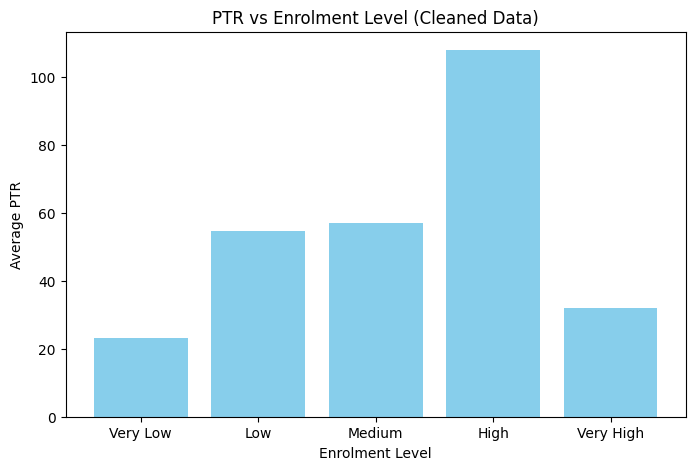

In [8]:
df_clean = df_base[df_base["total_tch"] > 0].copy()

min_enrol = df_clean["total_enrol"].min()
max_enrol = df_clean["total_enrol"].max()

#You can adjust these bin thresholds as per your dataset distribution
bins = [min_enrol, 3000, 6000, 9000, 12000, max_enrol]
labels = ["Very Low", "Low", "Medium", "High", "Very High"]

df_clean["enrol_level"] = pd.cut(
    df_clean["total_enrol"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_clean["PTR"] = df_clean["total_enrol"] / df_clean["total_tch"]

ptr_summary = df_clean.groupby("enrol_level")["PTR"].mean().reset_index()
print(ptr_summary)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(ptr_summary["enrol_level"], ptr_summary["PTR"], color='skyblue')
plt.title("PTR vs Enrolment Level (Cleaned Data)")
plt.xlabel("Enrolment Level")
plt.ylabel("Average PTR")
plt.show()


In [9]:
print(df_fac.columns)
print(df_fac.head())
print(df_fac.columns.isna().sum())

Index(['pseudocode', 'building_status', 'no_building_blocks',
       'pucca_building_blocks', 'boundary_wall', 'total_class_rooms',
       'other_rooms', 'classrooms_in_good_condition',
       'classrooms_needs_minor_repair', 'classrooms_needs_major_repair',
       'separate_room_for_hm', 'total_boys_toilet', 'total_boys_func_toilet',
       'total_girls_toilet', 'total_girls_func_toilet',
       'total_boys_cwsn_toilet', 'func_boys_cwsn_friendly',
       'total_girls_cwsn_toilet', 'func_girls_cwsn_friendly', 'urinal_boys',
       'urinal_girls', 'handwash_near_toilet', 'hand_pump_yn', 'well_prot_yn',
       'tap_yn', 'othsrc_yn', 'well_unprot_yn', 'pack_water_yn',
       'hand_pump_fun_yn', 'well_prot_fun_yn', 'tap_fun_yn', 'othsrc_fun_yn',
       'well_unprot_fun_yn', 'pack_water_fun_yn', 'rain_water_harvesting',
       'handwash_facility_for_meal', 'electricity_availability', 'solar_panel',
       'library_availability', 'book_bank', 'reading_corner',
       'playground_available', 

In [10]:
facility_binary_summary = df_clean.groupby("enrol_level")[binary_cols].mean().reset_index()
facility_binary_summary

C:\Users\itsme\AppData\Local\Temp\ipykernel_27940\1423162704.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  facility_binary_summary = df_clean.groupby("enrol_level")[binary_cols].mean().reset_index()


,enrol_level,boundary_wall,separate_room_for_hm,handwash_near_toilet,hand_pump_yn,tap_yn,othsrc_yn,well_unprot_yn,pack_water_yn,hand_pump_fun_yn,...,playground_alt_yn,medical_checkups,availability_ramps,availability_of_handrails,furniture_availability,comp_ict_lab_yn,ict_lab_yn,internet,dth,spl_educator_yn
0,Very Low,2.568910,1.424735,1.092769,1.355218,1.377414,1.893652,1.979256,1.916703,1.361772,...,6.896811,1.241515,1.206821,2.814020,1.640876,1.773173,6.828912,1.362039,1.856128,2.605624
1,Low,1.382295,1.021639,1.017705,1.560656,1.125902,1.796721,1.981639,1.836721,1.561967,...,8.040656,1.188852,1.127869,2.135738,1.120656,1.132459,5.921967,1.017705,1.577049,1.877377
2,Medium,1.368421,1.000000,1.017544,1.526316,1.122807,1.701754,1.964912,1.719298,1.543860,...,8.000000,1.210526,1.070175,1.666667,1.192982,1.105263,6.421053,1.017544,1.508772,1.859649
3,High,2.500000,1.000000,1.250000,1.500000,1.000000,2.000000,1.750000,2.000000,1.500000,...,5.500000,1.250000,1.250000,3.250000,1.750000,1.000000,3.000000,1.000000,1.750000,2.750000
4,Very High,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,...,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,3.000000


In [11]:
facility_count_summary = df_clean.groupby("enrol_level")[count_cols].mean().reset_index()
facility_count_summary

C:\Users\itsme\AppData\Local\Temp\ipykernel_27940\917357640.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  facility_count_summary = df_clean.groupby("enrol_level")[count_cols].mean().reset_index()


,enrol_level,no_building_blocks,pucca_building_blocks,total_class_rooms,other_rooms,classrooms_in_good_condition,classrooms_needs_minor_repair,classrooms_needs_major_repair,total_boys_toilet,total_boys_func_toilet,...,urinal_girls,laptop,tablet,desktop,digiboard,teachdev_tot,server_tot,smart_class_tv_tot,projector,printer
0,Very Low,0.293842,2.408727,0.838413,3.446782,6.084141,0.537263,0.553466,1.985798,1.886657,...,2.346194,0.635295,1.436606,3.275227,8.658869,0.614927,0.130057,0.641676,0.558272,0.567086
1,Low,0.939672,5.055082,14.561311,23.022295,75.509508,0.787541,0.508197,26.910820,26.418361,...,28.635410,9.940984,11.704262,80.193443,126.231475,23.672131,1.332459,24.401311,18.284590,7.655738
2,Medium,1.543860,6.508772,73.561404,30.578947,168.929825,1.736842,0.701754,66.508772,66.280702,...,58.333333,20.842105,16.368421,167.736842,267.719298,35.157895,1.561404,38.421053,29.877193,10.807018
3,High,1.000000,2.250000,16.000000,46.250000,75.000000,1.250000,0.500000,16.250000,16.250000,...,16.000000,2.250000,25.500000,150.000000,0.500000,3.000000,1.500000,2.500000,3.250000,7.250000
4,Very High,0.000000,12.000000,0.000000,20.000000,500.000000,0.000000,0.000000,250.000000,250.000000,...,250.000000,100.000000,10.000000,400.000000,0.000000,200.000000,5.000000,1.000000,40.000000,10.000000


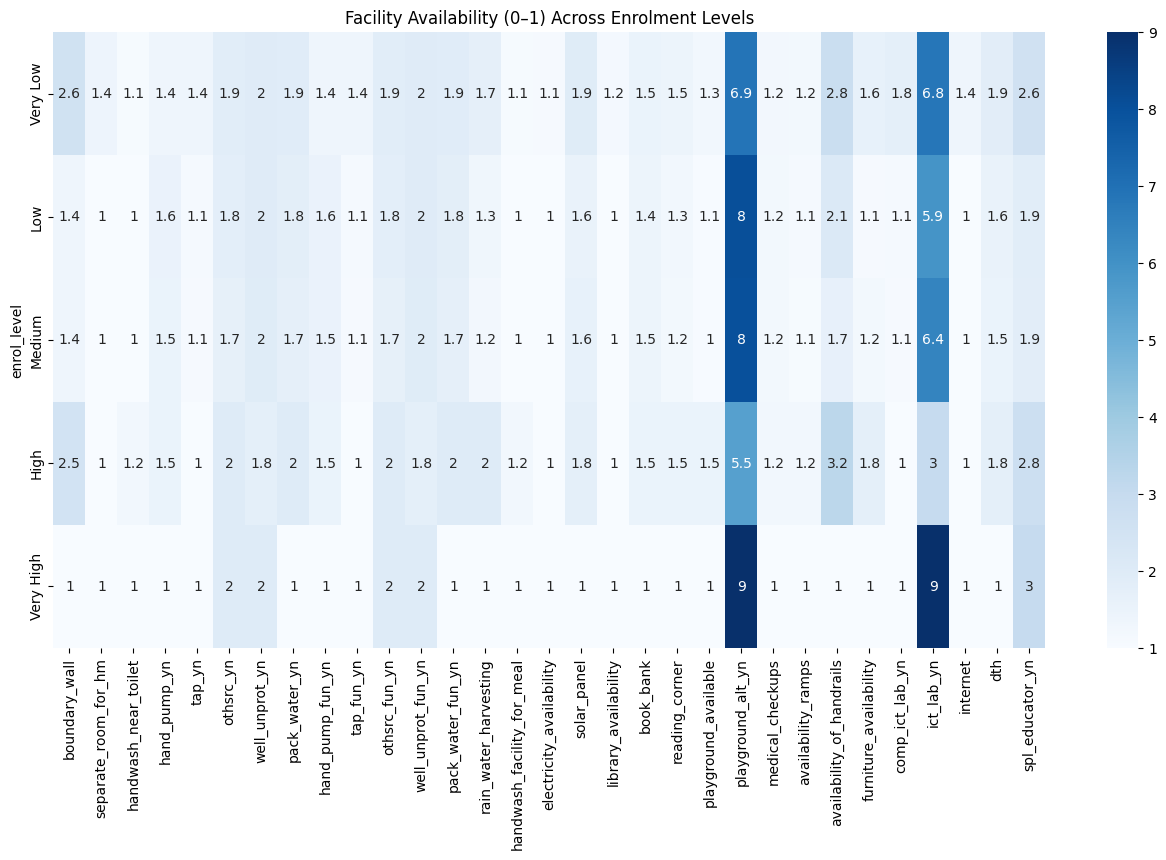

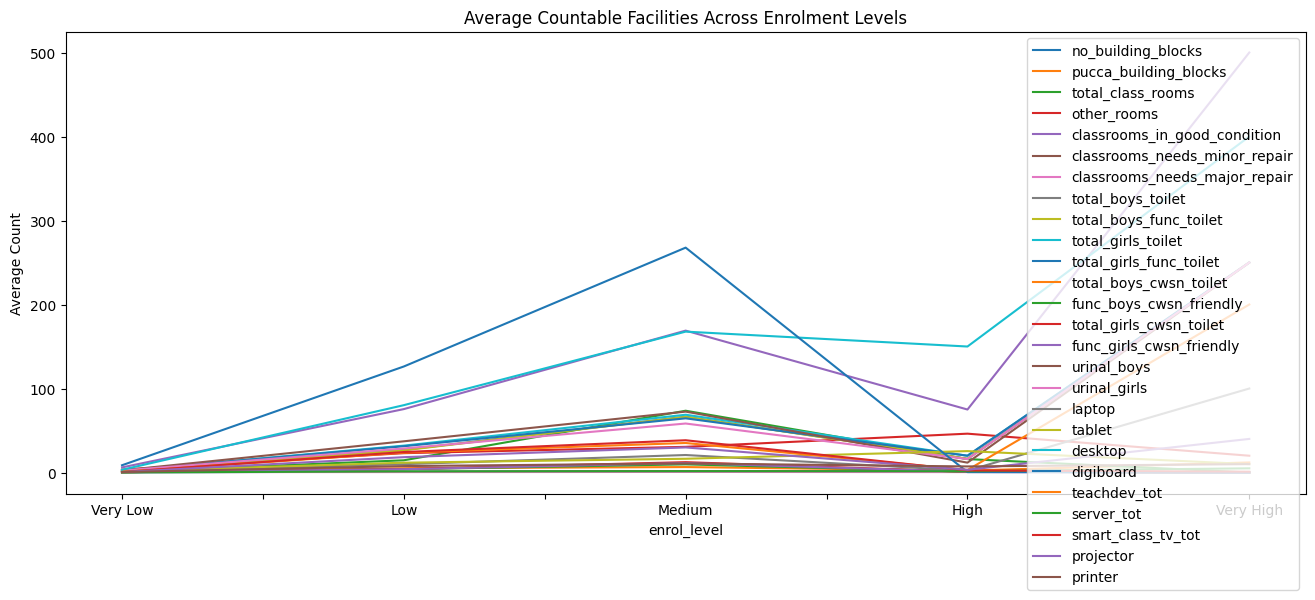

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,8))
sns.heatmap(facility_binary_summary.set_index("enrol_level"), annot=True, cmap="Blues")
plt.title("Facility Availability (0–1) Across Enrolment Levels")
plt.show()

facility_count_summary.plot(x="enrol_level", figsize=(16,6))
plt.title("Average Countable Facilities Across Enrolment Levels")
plt.ylabel("Average Count")
plt.show()

In [13]:
df_clean.head(10)

,pseudocode,total_enrol,total_tch,PTR,building_status,no_building_blocks,pucca_building_blocks,boundary_wall,total_class_rooms,other_rooms,...,digiboard,teachdev_tot,server_tot,smart_class_tv_tot,projector,printer,internet,dth,spl_educator_yn,enrol_level
0,1000002,76,3,25.333333,3,0,2,1,0,0,...,0,0,0,0,0,0,2,2,2,Very Low
1,1000019,32,2,16.000000,3,5,0,1,5,0,...,0,1,1,1,0,0,1,2,2,Very Low
2,1000021,62,1,62.000000,3,0,3,2,0,0,...,0,0,0,0,0,0,1,2,3,Very Low
3,1000028,42,4,10.500000,3,2,2,5,4,1,...,0,0,0,0,0,0,2,2,3,Very Low
4,1000029,352,16,22.000000,3,0,6,1,0,4,...,6,5,0,2,1,1,1,2,2,Very Low
5,1000031,275,9,30.555556,3,0,2,1,0,1,...,0,0,0,0,0,0,1,2,3,Very Low
6,1000032,32,2,16.000000,3,0,1,2,0,4,...,0,0,0,0,0,0,2,2,3,Very Low
7,1000035,251,9,27.888889,3,0,1,1,0,0,...,0,0,0,0,0,0,1,2,2,Very Low
8,1000040,269,12,22.416667,1,0,1,1,0,7,...,0,0,0,0,0,1,1,2,3,Very Low
9,1000047,175,9,19.444444,3,0,1,1,0,0,...,0,0,0,3,2,0,1,2,3,Very Low


In [14]:
df_clean.columns

Index(['pseudocode', 'total_enrol', 'total_tch', 'PTR', 'building_status',
       'no_building_blocks', 'pucca_building_blocks', 'boundary_wall',
       'total_class_rooms', 'other_rooms', 'classrooms_in_good_condition',
       'classrooms_needs_minor_repair', 'classrooms_needs_major_repair',
       'separate_room_for_hm', 'total_boys_toilet', 'total_boys_func_toilet',
       'total_girls_toilet', 'total_girls_func_toilet',
       'total_boys_cwsn_toilet', 'func_boys_cwsn_friendly',
       'total_girls_cwsn_toilet', 'func_girls_cwsn_friendly', 'urinal_boys',
       'urinal_girls', 'handwash_near_toilet', 'hand_pump_yn', 'well_prot_yn',
       'tap_yn', 'othsrc_yn', 'well_unprot_yn', 'pack_water_yn',
       'hand_pump_fun_yn', 'well_prot_fun_yn', 'tap_fun_yn', 'othsrc_fun_yn',
       'well_unprot_fun_yn', 'pack_water_fun_yn', 'rain_water_harvesting',
       'handwash_facility_for_meal', 'electricity_availability', 'solar_panel',
       'library_availability', 'book_bank', 'reading_corne

In [15]:
df_clean.to_csv("(24-25).csv", index=False)

C:\Users\itsme\AppData\Local\Temp\ipykernel_27940\1546653213.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ptr_reg_summary = df_clean.groupby('enrol_level')['PTR_Reg'].mean().reset_index()


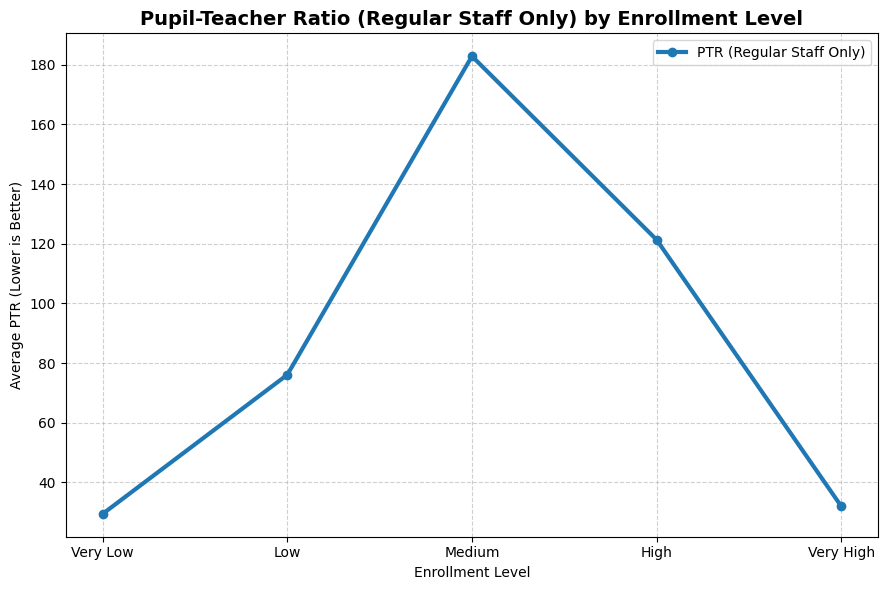

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Load the teacher dataset (must contain 'pseudocode', 'total_tch', and 'regular' columns)
df_tch = pd.read_csv("100_tch.csv").fillna(0)
teacher_data = df_tch[['pseudocode', 'total_tch', 'regular']].copy()

#Merge with your existing facility/enrollment dataset (df_clean should already exist in the notebook)
if 'df_clean' in locals():
    df_clean = df_clean.merge(teacher_data, on='pseudocode', how='left')
else:
    print("df_clean not found. Please ensure your main dataset variable exists before running this cell.")

#Calculate PTR for Regular Teachers Only
df_clean['PTR_Reg'] = df_clean.apply(
    lambda row: row['total_enrol'] / row['regular'] if row['regular'] > 0 else np.nan,
    axis=1
)

#Group by Enrollment Level and Compute Average
ptr_reg_summary = df_clean.groupby('enrol_level')['PTR_Reg'].mean().reset_index()

#Order Enrollment Levels Properly
order = ["Very Low", "Low", "Medium", "High", "Very High"]
ptr_reg_summary['enrol_level'] = pd.Categorical(ptr_reg_summary['enrol_level'], categories=order, ordered=True)
ptr_reg_summary = ptr_reg_summary.sort_values('enrol_level')

#Plot the PTR vs Enrollment Level Graph

plt.figure(figsize=(9, 6))
plt.plot(ptr_reg_summary['enrol_level'], ptr_reg_summary['PTR_Reg'], 
         marker='o', linewidth=3, label='PTR (Regular Staff Only)')

plt.title('Pupil-Teacher Ratio (Regular Staff Only) by Enrollment Level', fontsize=14, weight='bold')
plt.xlabel('Enrollment Level')
plt.ylabel('Average PTR (Lower is Better)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

ptr_reg_summary.to_csv("24-25 dataset2.csv", index=False)

In [17]:
df_fac.columns

Index(['pseudocode', 'building_status', 'no_building_blocks',
       'pucca_building_blocks', 'boundary_wall', 'total_class_rooms',
       'other_rooms', 'classrooms_in_good_condition',
       'classrooms_needs_minor_repair', 'classrooms_needs_major_repair',
       'separate_room_for_hm', 'total_boys_toilet', 'total_boys_func_toilet',
       'total_girls_toilet', 'total_girls_func_toilet',
       'total_boys_cwsn_toilet', 'func_boys_cwsn_friendly',
       'total_girls_cwsn_toilet', 'func_girls_cwsn_friendly', 'urinal_boys',
       'urinal_girls', 'handwash_near_toilet', 'hand_pump_yn', 'well_prot_yn',
       'tap_yn', 'othsrc_yn', 'well_unprot_yn', 'pack_water_yn',
       'hand_pump_fun_yn', 'well_prot_fun_yn', 'tap_fun_yn', 'othsrc_fun_yn',
       'well_unprot_fun_yn', 'pack_water_fun_yn', 'rain_water_harvesting',
       'handwash_facility_for_meal', 'electricity_availability', 'solar_panel',
       'library_availability', 'book_bank', 'reading_corner',
       'playground_available', 